## Fine gain notebook

In [1]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display
import matplotlib.pyplot as plt

import sys
sys.path.append("../common")
from driver_access import v4l2Ctrl
from config_parser import ConfigParser

i2c = v4l2Ctrl(sensor="mira050", printFunc=print)
def read_offset_clip():
    exp_val = i2c.rwReg(addr=0xE000, value=0, rw=1, flag=0) # WRITE bank sel 1
    exp_val_1 = i2c.rwReg(addr=0x0193, value= 0 >> 8 & 255, rw=0, flag=0) # READ registers 
    exp_val_2 = i2c.rwReg(addr=0x0194, value=0 & 255, rw=0, flag=0)


    
    print(f'offsetclip value in hex: {hex(exp_val_1)} {hex(exp_val_2)} ')
    print(f'offsetclip val in decimal: { 256* (exp_val_1) + (exp_val_2)}')
    return 256* (exp_val_1) + (exp_val_2)

In [2]:
amount = 10 #numbers of pictures to capture per setting
# gains = [1,2,4]
gains = np.arange(1,4.5,.5)
exposures_us = [500] #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 150
bit_mode = 10
save = False
#select mode a few cells below.
TIFF = True
UPLOAD_FOLDER = pathlib.Path("./images")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [3]:
#view camera model
pprint.pprint(Picamera2.global_camera_info())  #before init ;
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[0:44:22.134613076] [5516]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5-dirty (2024-08-22T17:47:10+02:00)
[0:44:23.255213380] [5535]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:23.266335273] [5535]  WARN RPI vc4.cpp:392 Mismatch between Unicam and CamHelper for embedded data usage!
[0:44:23.276091403] [5535]  INFO RPI vc4.cpp:446 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:44:23.276326382] [5535]  INFO RPI pipeline_base.cpp:1104 Using configuration file '/usr/local/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'


[{'Id': '/base/soc/i2c0mux/i2c@1/mira050@36',
  'Location': 2,
  'Model': 'mira050',
  'Num': 0,
  'Rotation': 0}]


[0:44:23.496343487] [5516]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5-dirty (2024-08-22T17:47:10+02:00)
[0:44:24.415512410] [5538]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:24.426153272] [5538]  WARN RPI vc4.cpp:392 Mismatch between Unicam and CamHelper for embedded data usage!
[0:44:24.432893677] [5538]  INFO RPI vc4.cpp:446 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:44:24.433090953] [5538]  INFO RPI pipeline_base.cpp:1104 Using configuration file '/usr/local/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:44:24.546973851] [5516]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5-dirty (2024-08-22T17:47:10+02:00)
[0:44:25.666586017] [5541]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:25.674458206] [5541]  WARN RPI vc4.cpp:392 Mismatch between Unicam and CamHelper 

[{'bit_depth': 10,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG10_CSI2P,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG12_CSI2P,
  'fps': 60.0,
  'size': (576, 768),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (58, 1000764, None),
  'format': SGRBG8,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG8'}]


[0:44:26.195561674] [5516]  INFO Camera camera.cpp:1183 configuring streams: (0) 640x480-XBGR8888 (1) 576x768-SGRBG12_CSI2P
[0:44:26.196605810] [5541]  INFO RPI vc4.cpp:621 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG12_1X12 - Selected unicam format: 576x768-pgCC
[0:44:26.226548528] [5516]  INFO Camera camera.cpp:1183 configuring streams: (0) 640x480-XBGR8888 (1) 576x768-SGRBG8
[0:44:26.227455592] [5541]  INFO RPI vc4.cpp:621 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG8_1X8 - Selected unicam format: 576x768-GRBG


In [4]:
for mode in modes:
    if mode['bit_depth']==bit_mode:
        break
selected_mode=mode

In [5]:
#DARK CONDITIONS
bit_mode = selected_mode["bit_depth"]
im_data = pd.DataFrame()
print(f'you have chosen mode {selected_mode}')

# with Picamera2() as picam2:
#     preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
#         raw={"format": selected_mode["unpacked"],
#             "size": selected_mode["size"],
#         })
#     picam2.configure(preview_config)
#     picam2.set_controls({"ExposureTime": 1000 , "AnalogueGain": 1})

#     picam2.start()

#     print(f'analog gain limits,1, : {picam2.camera_controls["AnalogueGain"]}')

    
with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        },queue= False, buffer_count =2)

    picam2.configure(preview_config)
    picam2.start()
    print(f'analog gain limits,2,: {picam2.camera_controls["AnalogueGain"]}')
    for analog_gain in gains:
        for exposure in [min_exposure]:
        
            picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
            
            time.sleep(.1)
            #raw = picam2.capture_buffer()
            #np.from_buffer
            
            size = selected_mode["size"]
        
            width = size[0]
            height = size[1]
            im_stack = []
            request = picam2.capture_request(flush=True)
            # with picam2.capture_request(flush=True) as request:
            for i in range(amount):
                metadata = picam2.capture_metadata()
                print(metadata["ExposureTime"], metadata["AnalogueGain"])
                if bit_mode == 8:
                    image = picam2.capture_array("raw").view(np.uint8)
                else:
                    image = picam2.capture_array("raw").view(np.uint16)
                im_stack.append(image[0:height, 0:width])
                if TIFF:
                    # save images    
                    pilim = Image.fromarray(image)
                    filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}_DARK_{i}.tiff")
                    pilim.save(filename)
            request.release()
            offsetclip=read_offset_clip()
            print(im_stack[0].mean())
            print(im_stack[8].mean())
            im_stack = im_stack[3:]
            # get & save images
            name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
            temp_im_dir = UPLOAD_FOLDER
            temp_im_path = pathlib.Path(temp_im_dir / name)
            if save:
                np.savez(str(temp_im_path), im_stack)
            mean_val = np.mean(im_stack)
            # add to image data
            temp = {'Analog Gain': [analog_gain],
                    'Bit Mode': [bit_mode],
                    'Exposure [us]': [exposure],
                    'Frame Count': [amount],
                    'Illumination': [False],
                    'mean [DN]': [mean_val],
                    'offsetclip':offsetclip,
                    'Image Path_npz': [str(pathlib.Path(temp_im_dir / name))]}
            
            temp = pd.DataFrame.from_dict(temp)

            # concat raw to im_data
            im_data = pd.concat([im_data, temp], ignore_index=True).reset_index(drop=True)
    

you have chosen mode {'format': SGRBG10_CSI2P, 'unpacked': 'SGRBG10', 'bit_depth': 10, 'size': (576, 768), 'fps': 120.08, 'crop_limits': (0, 0, 576, 768), 'exposure_limits': (58, 1000764, None)}


[0:44:26.678473352] [5516]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5-dirty (2024-08-22T17:47:10+02:00)
[0:44:27.195466759] [5545]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:27.197435403] [5545]  WARN RPI vc4.cpp:392 Mismatch between Unicam and CamHelper for embedded data usage!
[0:44:27.198937887] [5545]  INFO RPI vc4.cpp:446 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media0
[0:44:27.199048108] [5545]  INFO RPI pipeline_base.cpp:1104 Using configuration file '/usr/local/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:44:27.216887740] [5516]  INFO Camera camera_manager.cpp:313 libcamera v0.3.0+65-6ddd79b5-dirty (2024-08-22T17:47:10+02:00)
[0:44:27.234156341] [5548]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:27.235897136] [5548]  WARN RPI vc4.cpp:392 Mismatch between Unicam and CamHelper 

analog gain limits,2,: (0.0, 47.0, None)
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
150 1.0
offsetclip value in hex: 0x5 0xec 
offsetclip val in decimal: 1516
67.55266655815973
67.56680410879629
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
150 1.5
offsetclip value in hex: 0x5 0xf1 
offsetclip val in decimal: 1521
79.72811324508102
80.26080322265625
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
150 2.0
offsetclip value in hex: 0x5 0xf7 
offsetclip val in decimal: 1527
89.90908248336227
89.2910789207176
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
150 2.4779999256134033
offsetclip value in hex: 0x5 0xfc 
offsetclip val in decimal: 1532
98.54588035300925
99.15348307291667
150 2.9609999656677246
150 2.9609999656677246
150 2.9609999656677246
150 2.960

In [6]:
im_data

,Analog Gain,Bit Mode,Exposure [us],Frame Count,Illumination,mean [DN],offsetclip,Image Path_npz
0,1.0,10,150,10,False,67.578004,1516,images/bm=10_ag=1.0_fc=10_exp=150_dark.npz
1,1.5,10,150,10,False,80.203495,1521,images/bm=10_ag=1.5_fc=10_exp=150_dark.npz
2,2.0,10,150,10,False,89.462915,1527,images/bm=10_ag=2.0_fc=10_exp=150_dark.npz
3,2.5,10,150,10,False,98.650556,1532,images/bm=10_ag=2.5_fc=10_exp=150_dark.npz
4,3.0,10,150,10,False,107.799977,1537,images/bm=10_ag=3.0_fc=10_exp=150_dark.npz
5,3.5,10,150,10,False,115.887726,1543,images/bm=10_ag=3.5_fc=10_exp=150_dark.npz
6,4.0,10,150,10,False,125.453273,1549,images/bm=10_ag=4.0_fc=10_exp=150_dark.npz


<Axes: title={'center': '10bit'}, xlabel='Analog Gain', ylabel='mean [DN]'>

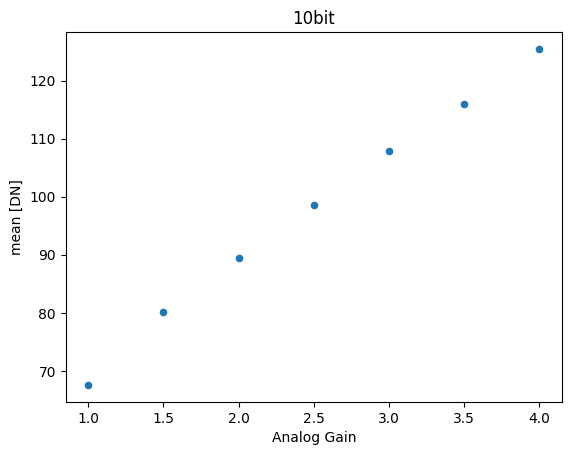

In [7]:
im_data.plot(kind = 'scatter', x = 'Analog Gain', y = 'mean [DN]', title = f"{bit_mode}bit")

In [8]:
print(im_stack[0].mean())
print(im_stack[8].mean())


124.91408736617477


IndexError: list index out of range